<a href="https://colab.research.google.com/github/roisetomy/MLOpenCampus/blob/main/C3W2Lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install keras-nlp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 691.2/691.2 kB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 86.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 850.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 57.8 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully uninstalled tensorboard-2.17.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.1
    Uninstalling tensorflow-2.17.1:
      Successfully uninstalled tensorflow-2.17.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompatible.


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import keras_nlp

In [ ]:
# Load the dataset
imdb = tfds.load("imdb_reviews", as_supervised=True, data_dir='./data', download=True)

as_supervised = True reads the data in the form of (review,label). Otherwise the data is presented in the form of some kind of dictionary.

In [ ]:
train_reviews = imdb['train'].map(lambda review, label: review)
train_labels = imdb['train'].map(lambda review, label: label)

test_reviews = imdb['test'].map(lambda review, label: review)
test_labels = imdb['test'].map(lambda review, label: label)

In [ ]:
# for element, label in imdb['train'].take(5):  # printing the elements of the loaded tensor dataset
#     print(element.numpy().decode('utf-8') + ' - ' + str(label.numpy()))

In [ ]:
# Show two reviews
list(train_reviews.take(2))

[<tf.Tensor: shape=(), dtype=string, numpy=b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.">,
 <tf.Tensor: shape=(), dtype=string, numpy=b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. Howev

In [ ]:
# Parameters for tokenization and padding
VOCAB_SIZE = 10000
MAX_LENGTH = 120
PADDING_TYPE = 'pre'
TRUNC_TYPE = 'post'

In [ ]:
# Instantiate the vectorization layer
vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE
)

# Generate the vocabulary based only on the training set
vectorize_layer.adapt(train_reviews)

Typical Values

    Standard NLP Tasks:
        5,000–30,000 tokens: Common for tasks like text classification or sentiment analysis.
    Language Models:
        50,000–100,000+ tokens: Often used in tasks requiring detailed semantic understanding (e.g., translation, summarization).
Trade-Offs

    Too Small a Vocabulary:
        Uncommon or rare words will be replaced with an "out-of-vocabulary" (OOV) token.
        This can hurt performance if the model loses important information.
    Too Large a Vocabulary:
        The model may become unnecessarily complex, slower to train, and prone to overfitting.
        The frequency of some rare tokens may be so low that they don’t contribute significantly.

In [ ]:
def padding_func(sequences):
  '''Generates padded sequences from a tf.data.Dataset
     The code converts text data into numerical sequences and ensures uniform sequence length through padding.
     This preprocessing step is essential for training machine learning models that expect fixed-size inputs, while leveraging TensorFlow's efficient data pipeline.
  '''

  # Put all elements in a single ragged batch
  sequences = sequences.ragged_batch(batch_size=sequences.cardinality())

  # Output a tensor from the single batch
  sequences = sequences.get_single_element()

  # Pad the sequences
  padded_sequences = tf.keras.utils.pad_sequences(sequences.numpy(),
                                                  maxlen=MAX_LENGTH,
                                                  truncating=TRUNC_TYPE,
                                                  padding=PADDING_TYPE
                                                 )

  # Convert back to a tf.data.Dataset
  padded_sequences = tf.data.Dataset.from_tensor_slices(padded_sequences)

  return padded_sequences

In [ ]:
# Apply the vectorization layer and padding on the training inputs
train_sequences = train_reviews.map(lambda text: vectorize_layer(text)).apply(padding_func)

In [ ]:
# Get the vocabulary
imdb_vocab_fullword = vectorize_layer.get_vocabulary()

# Get a sample integer sequence
sample_sequence = train_sequences.take(1).get_single_element()

# Lookup each token in the vocabulary
decoded_text = [imdb_vocab_fullword[token] for token in sample_sequence]

# Combine the words
decoded_text = ' '.join(decoded_text)

# Print the output
print(decoded_text)

    this was an absolutely terrible movie dont be [UNK] in by christopher walken or michael [UNK] both are great actors but this must simply be their worst role in history even their great acting could not redeem this movies ridiculous storyline this movie is an early nineties us propaganda piece the most pathetic scenes were those when the [UNK] rebels were making their cases for [UNK] maria [UNK] [UNK] appeared phony and her [UNK] affair with walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning i am disappointed that there are movies like this ruining actors like christopher [UNK] good name i could barely sit through it


Subword text encoding gets around this problem by using parts of the word to compose whole words. This makes it more flexible when it encounters uncommon words. You can use the KerasNLP API to do just that.


Handling Out-of-Vocabulary (OOV) Words:

    In traditional word-level tokenization, rare or unseen words are treated as unknown (OOV) tokens. Subword encoding avoids this by breaking down words into smaller units.
    Example:
        Word-level: "unpredictable" → ["unpredictable"] (OOV if not in vocabulary)
        Subword-level: "unpredictable" → ["un", "predict", "able"]

Efficient Vocabulary Size:

    Subword methods keep the vocabulary size manageable by representing rare words using combinations of common subwords.
    Example:
        "recharge", "rebuild", and "remake" can be split into ["re", "charge"], ["re", "build"], ["re", "make"].

Efficiency for Low-resource Languages:

    It reduces the need for a large vocabulary and helps models perform well even on small datasets.

In [ ]:
# Compute the subword vocabulary and save to a file
keras_nlp.tokenizers.compute_word_piece_vocabulary(
    train_reviews,
    vocabulary_size=8000,
    reserved_tokens=["[PAD]", "[UNK]"],
    vocabulary_output_file='imdb_vocab_subwords.txt'
)

In [ ]:
# Initialize the subword tokenizer
subword_tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(
    vocabulary='./imdb_vocab_subwords.txt'
)

In [ ]:
# Print the subwords
subword_tokenizer.get_vocabulary()

['[PAD]',
 '[UNK]',
 '!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 '{',
 '|',
 '}',
 '~',
 '',
 '¡',
 '¢',
 '£',
 '¤',
 '¦',
 '§',
 '¨',
 '«',
 '®',
 '°',
 '³',
 '´',
 '·',
 'º',
 '»',
 '½',
 '¾',
 '¿',
 'À',
 'Á',
 'Ã',
 'Ä',
 'Å',
 'È',
 'É',
 'Ê',
 'Õ',
 'Ø',
 'Ü',
 'ß',
 'à',
 'á',
 'â',
 'ã',
 'ä',
 'å',
 'æ',
 'ç',
 'è',
 'é',
 'ê',
 'ë',
 'ì',
 'í',
 'î',
 'ï',
 'ð',
 'ñ',
 'ò',
 'ó',
 'ô',
 'ö',
 'ø',
 'ù',
 'ú',
 'û',
 'ü',
 'ý',
 'ō',
 '–',
 '‘',
 '’',
 '“',
 '”',
 '…',
 '₤',
 '\uf0b7',
 't

In [ ]:
# Show the size of the subword vocabulary
subword_tokenizer.vocabulary_size()

7635

In [ ]:
# Get a sample review
sample_review = train_reviews.take(1).get_single_element()

# Encode the first plaintext sentence using the subword text encoder
tokenized_string = subword_tokenizer.tokenize(sample_review)
print ('Tokenized string is {}'.format(tokenized_string))

# Decode the sequence
original_string = subword_tokenizer.detokenize(tokenized_string)

# Print the result
print('The original string: {}'.format(original_string))

Tokenized string is [ 209  175  195  674  630  178   15  680    8   85  189   77 2000  170
  192 1766 4426  203  700   42 1864 2116   15 1961  185  255  328   13
  182  173  392  535  189  231  442  390  170  740   15  597  231  255
  282  263  186 1680 6036  173  178    8   84  908 1045   15  209  178
  168  195  638 4963 1657 1422 3263  637   15  176  258 1648  312  234
  330  223  164   36 1532 5576  758  326 4207  174  234  415  231 3925
  180 4554  174   15 3651   36  363 6855 1985 2230 1828  303 1931 7070
   13  165  202 5417   14  298 2118  179 4426  175  353  182   66 1648
 1210   81 7017  170   66  178  172  175 5789  166  269  324 1606   15
   42  427  938  172  219  185  266  199  173   13 3231  204  471    8
   84  199 1766 4426    8   84  210  627   15   42  263 1575 1169  320
  171   15]
The original string: This was an absolutely terrible movie . Don ' t be lured in by Christopher Walken or Michael Ironside . Both are great actors , but this must simply be their worst ro

Subword encoding can even perform well on words that are not commonly found in movie reviews. First, see the result when using the full-word tokenizer. As expected, it will show many unknown words.

In [ ]:
# Define sample sentence
sample_string = 'TensorFlow, from basics to mastery'

# Encode using the plain text tokenizer
tokenized_string = vectorize_layer(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

# Decode and print the result
decoded_text = [imdb_vocab_fullword[token] for token in tokenized_string]
original_string = ' '.join(decoded_text)
print ('The original string: {}'.format(original_string))

Tokenized string is [ 1 36  1  6  1]
The original string: [UNK] from [UNK] to [UNK]


In [ ]:
# Encode using the subword text encoder
tokenized_string_new = subword_tokenizer.tokenize(sample_string)
print('Tokenized string is:', tokenized_string_new)

# Decode the sequence
original_string = subword_tokenizer.detokenize(tokenized_string)

# Print the result
print('The original string: {}'.format(original_string))

Tokenized string is: tf.Tensor([  53 2235  543 1827 3024   13  198 1659  174  167 2220  238], shape=(12,), dtype=int32)
The original string: TensorFlow , from basics to mastery


As you may notice, the sentence is correctly decoded. The downside is the token sequence is much longer. Instead of only 5 when using the full-word tokenizer, you ended up with 12 tokens instead. The mapping for this sentence is shown below:

In [ ]:
# Show token to subword mapping:
for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, subword_tokenizer.detokenize([ts])))

53 ----> T
2235 ----> ##ens
543 ----> ##or
1827 ----> ##F
3024 ----> ##low
13 ----> ,
198 ----> from
1659 ----> basic
174 ----> ##s
167 ----> to
2220 ----> master
238 ----> ##y



## Training the model

You will now train your model using the subword-tokenized dataset using the same process as before.


In [ ]:
SHUFFLE_BUFFER_SIZE = 10000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE
BATCH_SIZE = 32

# Generate integer sequences using the subword tokenizer
train_sequences_subword = train_reviews.map(lambda review: subword_tokenizer.tokenize(review)).apply(padding_func)
test_sequences_subword = test_reviews.map(lambda review: subword_tokenizer.tokenize(review)).apply(padding_func)

# Combine the integer sequence and labels
train_dataset_vectorized = tf.data.Dataset.zip(train_sequences_subword,train_labels)
test_dataset_vectorized = tf.data.Dataset.zip(test_sequences_subword,test_labels)

# Optimize the datasets for training
train_dataset_final = (train_dataset_vectorized
                       .shuffle(SHUFFLE_BUFFER_SIZE)
                       .cache()
                       .prefetch(buffer_size=PREFETCH_BUFFER_SIZE)
                       .batch(BATCH_SIZE)
                       )

test_dataset_final = (test_dataset_vectorized
                      .cache()
                      .prefetch(buffer_size=PREFETCH_BUFFER_SIZE)
                      .batch(BATCH_SIZE)
                      )

In [ ]:
# Define dimensionality of the embedding
'''Each word (or subword) in the vocabulary will be represented as a vector of size 64.
 Larger dimensions allow capturing more complex relationships between tokens but can increase model complexity.
'''
EMBEDDING_DIM = 64

# Build the model
model = tf.keras.Sequential([
    tf.keras.Input(shape=(MAX_LENGTH,)),
    tf.keras.layers.Embedding(subword_tokenizer.vocabulary_size(), EMBEDDING_DIM),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Print the model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 120, 64)             │         488,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_1           │ (None, 64)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 6)                   │             390 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │               7 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 489,037 (1.87 MB)

 Trainable params: 489,037 (1.87 MB)

 Non-trainable params: 0 (0.00 B)

The Embedding Layer is used to map discrete, integer-encoded tokens (from text tokenization) into dense, continuous-valued vectors.

    Transforms Sparse Representation into Dense Representation:
    The embedding layer represents tokens in a dense vector space where relationships between words (or subwords) can be captured.

    Learnable Representations:
    The embedding vectors are trainable. During training, the embedding layer learns to map tokens with similar semantic meanings closer in the embedding space.

    Dimensionality Reduction:
    Instead of one-hot encoding, which results in high-dimensional sparse vectors, the embedding layer reduces the token representation to a lower-dimensional dense space (EMBEDDING_DIM).

    Improves Generalization:
    The dense embeddings help the model generalize better, as semantically related words will have similar representations.

In [ ]:
num_epochs = 10

# Set the training parameters
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Start training
history = model.fit(train_dataset_final, epochs=num_epochs, validation_data=test_dataset_final)

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - accuracy: 0.6830 - loss: 0.6045 - val_accuracy: 0.7852 - val_loss: 0.4526
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.8393 - loss: 0.3732 - val_accuracy: 0.7921 - val_loss: 0.4467
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 0.8678 - loss: 0.3176 - val_accuracy: 0.7877 - val_loss: 0.4680
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.8814 - loss: 0.2895 - val_accuracy: 0.7832 - val_loss: 0.4940
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.8897 - loss: 0.2710 - val_accuracy: 0.7802 - val_loss: 0.5208
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.8964 - loss: 0.2573 - val_accuracy: 0.7775 - val_loss: 0.5438
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.9024 - loss: 0.2462 - val_accuracy: 0.7743 - val_loss: 0.5687
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9076 - loss: 0.2370 - 

<ipython-input-35-fe2f79507b73>:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax[0].plot(epochs, acc, 'b', label='Training accuracy', color='red')
<ipython-input-35-fe2f79507b73>:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax[1].plot(epochs, loss, 'b', label='Training Loss', color='red')


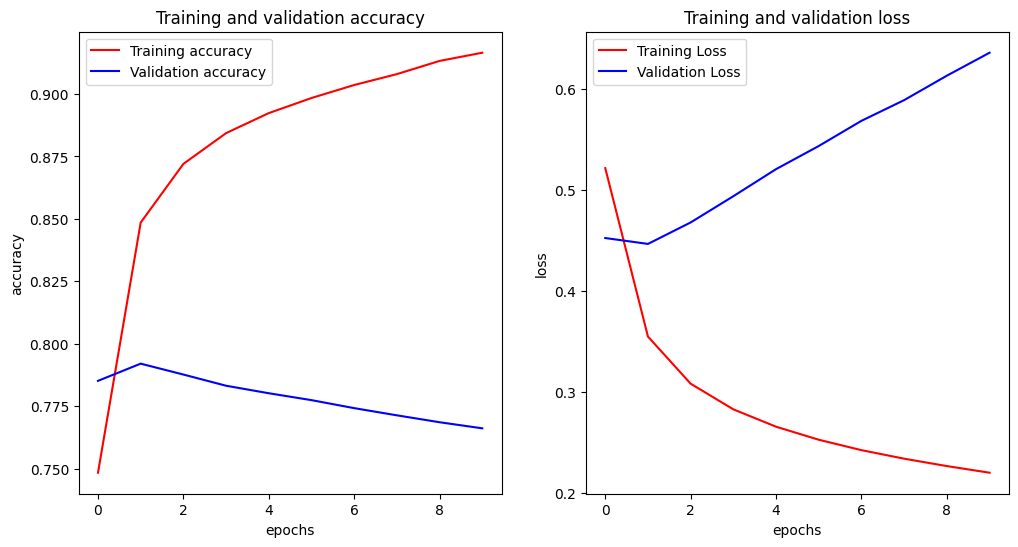

In [ ]:
def plot_loss_acc(history):
  '''Plots the training and validation loss and accuracy from a history object'''
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  fig, ax = plt.subplots(1,2, figsize=(12, 6))
  ax[0].plot(epochs, acc, 'b', label='Training accuracy', color='red')
  ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
  ax[0].set_title('Training and validation accuracy')
  ax[0].set_xlabel('epochs')
  ax[0].set_ylabel('accuracy')
  ax[0].legend()

  ax[1].plot(epochs, loss, 'b', label='Training Loss', color='red')
  ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
  ax[1].set_title('Training and validation loss')
  ax[1].set_xlabel('epochs')
  ax[1].set_ylabel('loss')
  ax[1].legend()

  plt.show()

plot_loss_acc(history)